In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Listar el contenido del directorio principal de Drive
!ls "/content/drive/Shared drives"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Analisis I'
 AutoEvaluaciónProfesoradoMatemática
'Curso aprendizaje automático 2023'
'Diplo Análisis de datos Ciencias Sociales'
'Estadística descriptiva aplicada a la investigación'
 Funesil
 Grabaciones_Estadistica_descriptiva_aplicada_a_la_investigación
 Profesorado
 ProyectoUNVM-2023-2024
'Rocío doctorado'


In [11]:
 #Comprueba las carpetas y archivos
!ls "/content/drive/Shared drives/Rocío doctorado/Proyecto NLP/Datos"


aborto_junio_tweets.csv				      LDA_decision_tree_metrics_chi.csv
aborto_junio_users.csv				      LDA_decision_tree_metrics.csv
aborto_junio_users.xlsx				      LDA_decision_tree_results_sorted.csv
adaboost_metrics_chi.csv			      LDA_gradient_boosting_metrics_chi.csv
adaboost_metrics.csv				      LDA_gradient_boosting_metrics.csv
Analisis_sentimiento_comunidades.csv		      LDA_logistic_regression_metrics_chi.csv
Analisis_sentimiento_LDA.csv			      LDA_logistic_regression_metrics.csv
baseline_metrics.csv				      LDA_logistic_regression_results_sorted.csv
baseline_metrics_LDA.csv			      LDA_modelos_chi.csv
Caracteristicas_comunidades.csv			      LDA_modelos.csv
Caracteristicas_LDA.csv				      LDA_random_forest_metrics_chi.csv
Comunidades					      LDA_random_forest_metrics.csv
comunidades.csv					      LDA_resultados_adaboost.csv
comunidades_modelos_chi.csv			      LDA_resultados_gradient_boosting.csv
comunidades_modelos.csv				      LDA_resultados_random_forest.csv
comunidades_mod

In [12]:


# Si el archivo aparece en la lista, puedes proceder a leerlo:
import pandas as pd
ruta_archivo = '/content/drive/Shared drives/Rocío doctorado/Proyecto NLP/Datos/Caracteristicas_comunidades.csv'
data = pd.read_csv(ruta_archivo)

# Muestra las primeras filas del archivo
data.shape


(110409, 17)

In [13]:
!pip install fasttext


In [14]:
from sklearn.model_selection import train_test_split
# Separar el conjunto de datos en entrenamiento y prueba
data = data.dropna(subset=['postura', 'full_text_cleaned'])

data_train, data_test = train_test_split(data, test_size=0.3, random_state=42, stratify=data['postura'])

# Crear un archivo de texto para el conjunto de entrenamiento
with open("fasttext_train.txt", "w") as f_train:
    for i, row in data_train.iterrows():
        etiqueta = row["postura"]
        texto = row["full_text_cleaned"]
        f_train.write(f"__label__{etiqueta} {texto}\n")

# Crear un archivo de texto para el conjunto de prueba
with open("fasttext_test.txt", "w") as f_test:
    for i, row in data_test.iterrows():
        etiqueta = row["postura"]
        texto = row["full_text_cleaned"]
        f_test.write(f"__label__{etiqueta} {texto}\n")

print("Archivos creados: fasttext_train.txt y fasttext_test.txt")

Archivos creados: fasttext_train.txt y fasttext_test.txt


Entrenamos con el modelo que no sobreajusta

Mejores hiperparámetros encontrados:
{'epoch': 25, 'lr': 0.01, 'dim': 100}
Mejor F1-Score en Validación: 0.8470


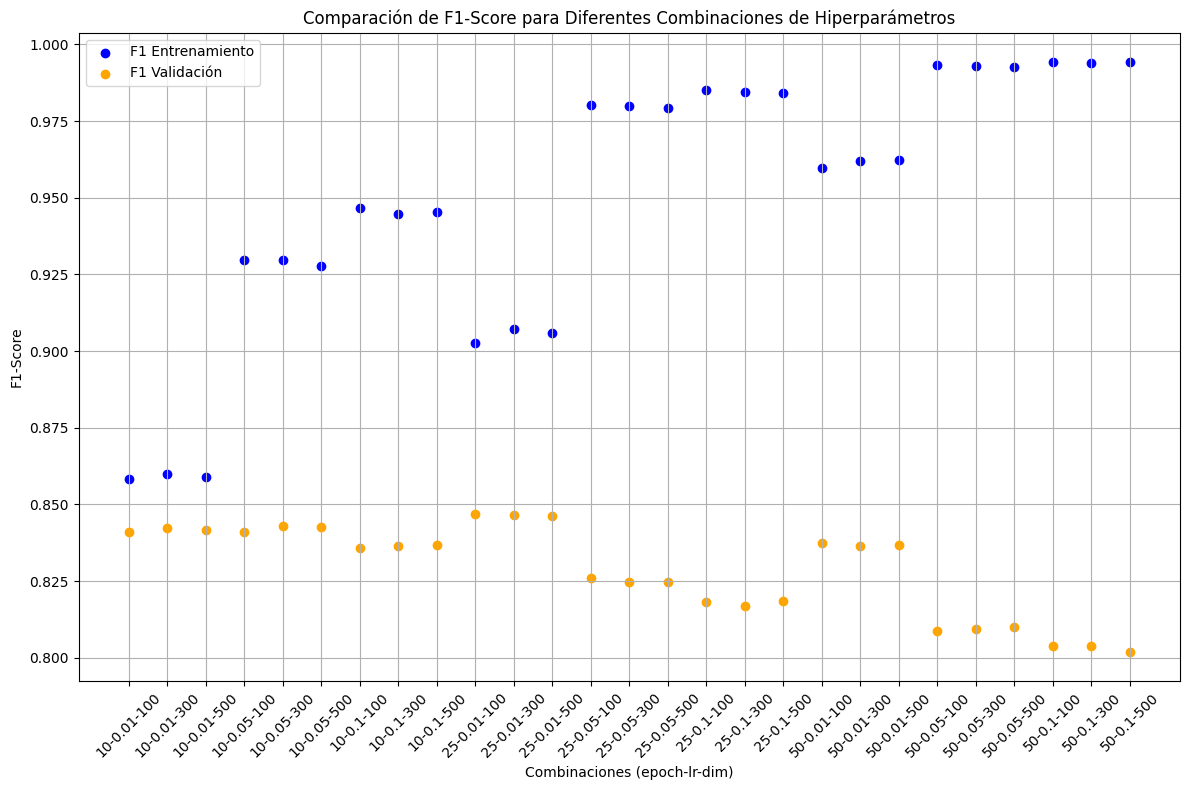

In [9]:
from sklearn.metrics import f1_score
import fasttext
import matplotlib.pyplot as plt

# Definir los valores de los hiperparámetros a probar
epocas_list = [10, 25, 50]  # Número de épocas
lr_list = [0.01, 0.05, 0.1]  # Tasa de aprendizaje
dim_list = [100, 300, 500]   # Dimensionalidad del vector de palabras

# Variables para almacenar los mejores resultados y métricas
mejor_f1_validacion = 0
mejores_parametros = {}

# Variables para almacenar métricas para cada combinación
resultados = []

# Validación cruzada sobre los hiperparámetros
for epocas in epocas_list:
    for lr in lr_list:
        for dim in dim_list:
            # Listas para almacenar métricas de entrenamiento y validación
            entrenamiento_f1 = []
            validacion_f1 = []

            # Entrenamiento del modelo para cada combinación de hiperparámetros
            modelo = fasttext.train_supervised("fasttext_train.txt", epoch=epocas, lr=lr, dim=dim)

            # Evaluar en el conjunto de entrenamiento
            y_train_pred, _ = modelo.predict(data_train['full_text_cleaned'].tolist())
            y_train_pred = [label[0].split("__")[-1] for label in y_train_pred]
            y_train_true = [str(label) for label in data_train['postura'].tolist()]

            # Calcular F1-Score en entrenamiento
            f1_train = f1_score(y_train_true, y_train_pred, average='macro')
            entrenamiento_f1.append(f1_train)

            # Evaluar en el conjunto de validación
            y_val_pred, _ = modelo.predict(data_test['full_text_cleaned'].tolist())
            y_val_pred = [label[0].split("__")[-1] for label in y_val_pred]
            y_val_true = [str(label) for label in data_test['postura'].tolist()]

            # Calcular F1-Score en validación
            f1_val = f1_score(y_val_true, y_val_pred, average='macro')
            validacion_f1.append(f1_val)

            # Guardar métricas para esta combinación
            resultados.append({
                'epoch': epocas,
                'lr': lr,
                'dim': dim,
                'f1_train': f1_train,
                'f1_validacion': f1_val
            })

            # Actualizar mejores parámetros si el F1-Score en validación mejora
            if f1_val > mejor_f1_validacion:
                mejor_f1_validacion = f1_val
                mejores_parametros = {
                    'epoch': epocas,
                    'lr': lr,
                    'dim': dim
                }

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(mejores_parametros)
print(f"Mejor F1-Score en Validación: {mejor_f1_validacion:.4f}")

# Visualización de los resultados de F1-Score
plt.figure(figsize=(12, 8))

# Gráfica de F1-Score para cada combinación de hiperparámetros
for result in resultados:
    combinacion = f"{result['epoch']}-{result['lr']}-{result['dim']}"
    plt.scatter(combinacion, result['f1_train'], color='blue', label='F1 Entrenamiento' if combinacion == f"{epocas_list[0]}-{lr_list[0]}-{dim_list[0]}" else "")
    plt.scatter(combinacion, result['f1_validacion'], color='orange', label='F1 Validación' if combinacion == f"{epocas_list[0]}-{lr_list[0]}-{dim_list[0]}" else "")

plt.title('Comparación de F1-Score para Diferentes Combinaciones de Hiperparámetros')
plt.xlabel('Combinaciones (epoch-lr-dim)')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, roc_auc_score
import fasttext
import numpy as np

# Variables para almacenar métricas
entrenamiento_precision = []
validacion_precision = []
entrenamiento_recall = []
validacion_recall = []
entrenamiento_f1 = []  # Para almacenar el F1-Score de entrenamiento
validacion_f1 = []     # Para almacenar el F1-Score de validación
entrenamiento_auc = []
validacion_auc = []

# Definir el número de épocas a 25
num_epocas = 10

# Entrenar el modelo solo para 2 épocas
modelo = fasttext.train_supervised("fasttext_train.txt", epoch=num_epocas, lr=0.01, dim=100)

# Evaluar el modelo en el conjunto de entrenamiento
resultado_train = modelo.test("fasttext_train.txt")

# Predecir las etiquetas para el conjunto de entrenamiento
y_train_pred, _ = modelo.predict(data_train['full_text_cleaned'].tolist())
y_train_pred = [label[0].split("__")[-1] for label in y_train_pred]  # Extraer solo la etiqueta

# Obtener las etiquetas verdaderas
y_train_true = data_train['postura'].tolist()

# Asegurar que ambos son del mismo tipo
y_train_true = [str(label) for label in y_train_true]
y_train_pred = [str(label) for label in y_train_pred]

# Calcular las métricas para el conjunto de entrenamiento
entrenamiento_precision.append(resultado_train[1])  # Precisión en entrenamiento
entrenamiento_recall.append(recall_score(y_train_true, y_train_pred, average='macro'))
entrenamiento_f1.append(f1_score(y_train_true, y_train_pred, average='macro'))

# Calcular el ROC AUC (necesita las probabilidades de predicción)
# Cambiado el método para obtener las probabilidades
y_train_prob = modelo.predict(data_train['full_text_cleaned'].tolist(), k=-1)[1]
y_train_prob = np.array([list(map(float, pred)) for pred in y_train_prob])  # Convertir a un array NumPy

# Suponiendo que estamos trabajando con un problema binario, selecciona las probabilidades de la clase positiva (1)
entrenamiento_auc.append(roc_auc_score(y_train_true, y_train_prob[:, 1]))  # Asegúrate de que esto tiene sentido para tu caso

# Evaluar el modelo en el conjunto de validación
resultado_val = modelo.test("fasttext_test.txt")

# Predecir las etiquetas para el conjunto de validación
y_val_pred, _ = modelo.predict(data_test['full_text_cleaned'].tolist())
y_val_pred = [label[0].split("__")[-1] for label in y_val_pred]  # Extraer solo la etiqueta

# Obtener las etiquetas verdaderas del conjunto de validación
y_val_true = data_test['postura'].tolist()

# Asegurar que ambos son del mismo tipo
y_val_true = [str(label) for label in y_val_true]
y_val_pred = [str(label) for label in y_val_pred]

# Calcular las métricas para el conjunto de validación
validacion_precision.append(resultado_val[1])  # Precisión en validación
validacion_recall.append(recall_score(y_val_true, y_val_pred, average='macro'))
validacion_f1.append(f1_score(y_val_true, y_val_pred, average='macro'))

# Calcular el ROC AUC para el conjunto de validación
y_val_prob = modelo.predict(data_test['full_text_cleaned'].tolist(), k=-1)[1]
y_val_prob = np.array([list(map(float, pred)) for pred in y_val_prob])  # Convertir a un array NumPy

# Suponiendo que estamos trabajando con un problema binario, selecciona las probabilidades de la clase positiva (1)
validacion_auc.append(roc_auc_score(y_val_true, y_val_prob[:, 1]))  # Asegúrate de que esto tiene sentido para tu caso

# Función para calcular especificidad
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Calcular especificidad
especificidad_entrenamiento = specificity(y_train_true, y_train_pred)
especificidad_validacion = specificity(y_val_true, y_val_pred)

# Imprimir las métricas finales
print(f"Modelo ajustado para 10 épocas: "
      f"Precisión Entrenamiento = {entrenamiento_precision[-1]:.4f}, "
      f"Recall Entrenamiento = {entrenamiento_recall[-1]:.4f}, "
      f"Especificidad Entrenamiento = {especificidad_entrenamiento:.4f}, "
      f"F1-Score Entrenamiento = {entrenamiento_f1[-1]:.4f}, "
      f"ROC AUC Entrenamiento = {entrenamiento_auc[-1]:.4f}")

print(f"Precisión Validación = {validacion_precision[-1]:.4f}, "
      f"Recall Validación = {validacion_recall[-1]:.4f}, "
      f"Especificidad Validación = {especificidad_validacion:.4f}, "
      f"F1-Score Validación = {validacion_f1[-1]:.4f}, "
      f"ROC AUC Validación = {validacion_auc[-1]:.4f}")


Modelo ajustado para 10 épocas: Precisión Entrenamiento = 0.8650, Recall Entrenamiento = 0.8507, Especificidad Entrenamiento = 0.7718, F1-Score Entrenamiento = 0.8573, ROC AUC Entrenamiento = 0.4715
Precisión Validación = 0.8507, Recall Validación = 0.8351, Especificidad Validación = 0.7487, F1-Score Validación = 0.8418, ROC AUC Validación = 0.4760
